加载包

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from shap import TreeExplainer, Explanation
import shap
import pandas as pd
import numpy as np
import graphviz
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt

首先简单训练一个模型：

In [9]:
data = pd.read_csv(f"{BASE_DIR}/data/data.csv")
data.drop(["INPATIENT_ID", "SEX", "INJURY_TYPE", "INJURY_CAUSE"], axis=1, inplace=True)
data = data.dropna(axis=0)

# NOTE: 这里是Pandas表格形式而非Numpy数组
X_df, Y_df = data[data.columns.drop("VTE")], data["VTE"]

X_train, X_test, y_train, y_test = train_test_split(
    X_df, Y_df, test_size=0.3, shuffle=True, random_state=0)

model = RandomForestClassifier(n_estimators=100,)
model.fit(X_train, y_train)

RandomForestClassifier()

接下来，对上述随机森林模型进行解释：

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
explainer.expected_value

array([0.77551418, 0.22448582])

计算各测试样本上所有特征的SHAP值：

In [12]:
shap_values = explainer(X_test)  # shape=(sample_size, feature, label)
print(f"SHAP values shape: {shap_values.values.shape}")
print(f"SHAP base-values shape: {shap_values.base_values.shape}")

SHAP values shape: (242, 66, 2)
SHAP base-values shape: (242, 2)


这里对上述SHAP值的格式和意义进行解释：
* shap.base_values：shape=(N, targets)表示在模型训练过程中通过**所有训练样本**获得的各目标预测分数的期望（均值）。模型训练完毕后，该值不变；
* shap.values：shape=(N, features, targets)表示用于SHAP计算样本中各特征关于各特征的SHAP贡献值；

首先，证明SHAP基准值与样本无关：

In [13]:
shap_values = explainer(X_train)  # shape=(N, features, targets)
print(shap_values.base_values[0, :])

shap_values = explainer(X_test)  # shape=(N, features, targets)
print(shap_values.base_values[0, :])

print(explainer.expected_value)

[0.77551418 0.22448582]
[0.77551418 0.22448582]
[0.77551418 0.22448582]


接下来，显示SHAP值计算结果形式：

In [14]:
shap_values = explainer(X_test)  # shape=(N, features, targets)
print(shap_values)
# print(shap_values.values.shape)

.values =
array([[[-0.00739769,  0.00739769],
        [ 0.04619388, -0.04619388],
        [-0.01450951,  0.01450951],
        ...,
        [-0.0064294 ,  0.0064294 ],
        [-0.01173274,  0.01173274],
        [-0.00413206,  0.00413206]],

       [[-0.00465709,  0.00465709],
        [-0.02350125,  0.02350125],
        [ 0.01864915, -0.01864915],
        ...,
        [ 0.0110712 , -0.0110712 ],
        [-0.01784972,  0.01784972],
        [-0.00669646,  0.00669646]],

       [[-0.00699152,  0.00699152],
        [-0.00474231,  0.00474231],
        [-0.02327095,  0.02327095],
        ...,
        [ 0.0002004 , -0.0002004 ],
        [-0.00384146,  0.00384146],
        [-0.00552989,  0.00552989]],

       ...,

       [[-0.00646671,  0.00646671],
        [ 0.03319847, -0.03319847],
        [-0.03263158,  0.03263158],
        ...,
        [-0.01314509,  0.01314509],
        [ 0.0001999 , -0.0001999 ],
        [ 0.0028798 , -0.0028798 ]],

       [[ 0.0114332 , -0.0114332 ],
        [-0.01125

##### **画图**

In [15]:
shap.initjs()

In [16]:
x = X_test.iloc[0, :]
x

CHEMOPROPHYLAXIS       1.00
AGE                   31.00
ISS                   22.00
CAPRINI_SCORE         11.00
SURGERY                1.00
                     ...   
PT                    11.30
FIB                    4.08
DD                     5.79
CK                  1142.00
INR                    0.92
Name: 9, Length: 66, dtype: float64

In [17]:
shap_values = explainer.shap_values(X_test)  # shape=(N, features, targets)
shap_values  # NOTE: 这是一个分类问题，所以shap_values是一个对应于不同目标的list

[array([[-0.00739769,  0.04619388, -0.01450951, ..., -0.0064294 ,
         -0.01173274, -0.00413206],
        [-0.00465709, -0.02350125,  0.01864915, ...,  0.0110712 ,
         -0.01784972, -0.00669646],
        [-0.00699152, -0.00474231, -0.02327095, ...,  0.0002004 ,
         -0.00384146, -0.00552989],
        ...,
        [-0.00646671,  0.03319847, -0.03263158, ..., -0.01314509,
          0.0001999 ,  0.0028798 ],
        [ 0.0114332 , -0.01125113,  0.01301448, ...,  0.01989658,
          0.00387821, -0.00193681],
        [-0.00671057, -0.01311392,  0.0236871 , ..., -0.01251322,
         -0.0104324 ,  0.00562762]]),
 array([[ 0.00739769, -0.04619388,  0.01450951, ...,  0.0064294 ,
          0.01173274,  0.00413206],
        [ 0.00465709,  0.02350125, -0.01864915, ..., -0.0110712 ,
          0.01784972,  0.00669646],
        [ 0.00699152,  0.00474231,  0.02327095, ..., -0.0002004 ,
          0.00384146,  0.00552989],
        ...,
        [ 0.00646671, -0.03319847,  0.03263158, ...,  

上述通过explainer.shap_values()获得的shap_values是一个list，里面不同元素表示不同目标上的SHAP值。

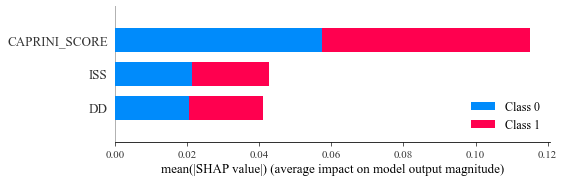

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=3)

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000, :], X_test.iloc[:1000,:])

In [20]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0,:])

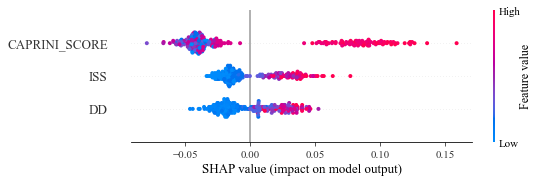

In [27]:
shap.summary_plot(shap_values[1], X_test, max_display=3)

个别特征的依赖图

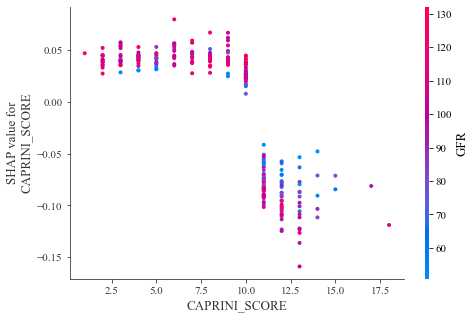

In [22]:
shap.dependence_plot("CAPRINI_SCORE", shap_values[0], X_test, display_features=X_test)

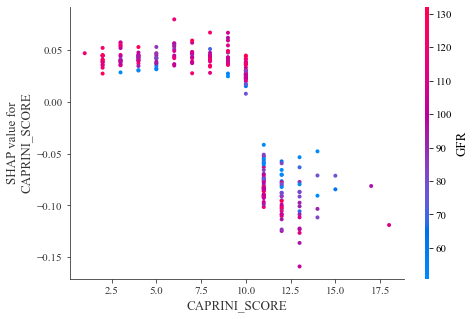

In [23]:
shap_values_ind = shap.TreeExplainer(model).shap_values(X_test)
shap.dependence_plot("CAPRINI_SCORE", shap_values_ind[0], X_test, display_features=X_test)